<a href="https://colab.research.google.com/github/Vetyugov/ML/blob/master/classifiers/Uplift_%26_CLTV_%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_XGBClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Полное задание

1. Откройте файл с данными для uplift-моделирования.
2. Проанализируйте данные:
*   признаки клиентов;
*   группы клиентов;
* распределение признаков и т. д.
3. Разделите выборки для обучения модели.
4. Обучите модель XGBClassifier.
5. Оцените качество построенной модели.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Путь до загруженного файла с данными
FILE_PATH = '/content/drive/MyDrive/МФТИ/Большие данные в финансах/Тема 7. Uplift & CLTV.  Модель XGBClassifier/uplift_synthetic_data_100trials.csv'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 1. Откройте файл с данными для uplift-моделирования.

In [ ]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns, math, os, warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv(FILE_PATH)
df.head()

,Unnamed: 0,trial_id,treatment_group_key,conversion,control_conversion_prob,treatment1_conversion_prob,treatment1_true_effect,x1_informative,x2_informative,x3_informative,...,x27_irrelevant,x28_irrelevant,x29_irrelevant,x30_irrelevant,x31_uplift_increase,x32_uplift_increase,x33_uplift_increase,x34_uplift_increase,x35_uplift_increase,x36_uplift_increase
0,0,0,control,1,0.516606,0.572609,0.056002,-1.926651,1.233472,-0.475120,...,-0.378145,-0.110782,1.087180,-1.222069,-0.279009,1.013911,-0.570859,-1.158216,-1.336279,-0.708056
1,1,0,treatment1,1,0.304005,0.736460,0.432454,0.904364,0.868705,-0.285977,...,-0.742847,0.700239,0.001867,-0.069362,0.045789,1.364182,-0.261643,0.478074,0.531477,0.402723
2,2,0,treatment1,0,0.134277,0.480985,0.346709,1.680978,1.320889,0.059273,...,0.748884,-0.856898,-0.268034,-2.181874,1.473214,-1.256641,0.901139,2.029204,-0.280445,0.873970
3,3,0,treatment1,1,0.801968,0.858532,0.056563,-0.335774,-2.940232,-0.302521,...,0.151074,0.067547,-0.839246,0.587575,0.412081,0.141189,0.369611,-0.364984,-1.509045,-1.335023
4,4,0,control,0,0.063552,0.060142,-0.003410,-0.475881,-0.485793,0.978582,...,-1.287117,1.256396,-1.155307,-0.414787,1.163851,0.698114,0.088157,0.478717,-0.680588,-2.730850


# 2. Проанализируйте данные:
# *   признаки клиентов;
# *   группы клиентов;
# *   распределение признаков и т. д.

In [ ]:
df_model = df.copy()
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 43 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Unnamed: 0                  1000000 non-null  int64  
 1   trial_id                    1000000 non-null  int64  
 2   treatment_group_key         1000000 non-null  object 
 3   conversion                  1000000 non-null  int64  
 4   control_conversion_prob     1000000 non-null  float64
 5   treatment1_conversion_prob  1000000 non-null  float64
 6   treatment1_true_effect      1000000 non-null  float64
 7   x1_informative              1000000 non-null  float64
 8   x2_informative              1000000 non-null  float64
 9   x3_informative              1000000 non-null  float64
 10  x4_informative              1000000 non-null  float64
 11  x5_informative              1000000 non-null  float64
 12  x6_informative              1000000 non-null  float64
 13

 Вывод: в данных нет пустых полей, тип даннных не проставлен только для столбца treatment_group_key.
 Проверим уникальность значений этого столбца



In [ ]:
df_treatment = df_model['treatment_group_key']
for unique_obj in df_treatment.unique():
  print(f'{unique_obj} : {sum(df_treatment == unique_obj)}' )


control : 500000
treatment1 : 500000


Получилось 2 типа данных

In [ ]:
df_model['treatment_group_key'] = df_model['treatment_group_key'].astype('category')
df_model.head()

,Unnamed: 0,trial_id,treatment_group_key,conversion,control_conversion_prob,treatment1_conversion_prob,treatment1_true_effect,x1_informative,x2_informative,x3_informative,...,x27_irrelevant,x28_irrelevant,x29_irrelevant,x30_irrelevant,x31_uplift_increase,x32_uplift_increase,x33_uplift_increase,x34_uplift_increase,x35_uplift_increase,x36_uplift_increase
0,0,0,control,1,0.516606,0.572609,0.056002,-1.926651,1.233472,-0.475120,...,-0.378145,-0.110782,1.087180,-1.222069,-0.279009,1.013911,-0.570859,-1.158216,-1.336279,-0.708056
1,1,0,treatment1,1,0.304005,0.736460,0.432454,0.904364,0.868705,-0.285977,...,-0.742847,0.700239,0.001867,-0.069362,0.045789,1.364182,-0.261643,0.478074,0.531477,0.402723
2,2,0,treatment1,0,0.134277,0.480985,0.346709,1.680978,1.320889,0.059273,...,0.748884,-0.856898,-0.268034,-2.181874,1.473214,-1.256641,0.901139,2.029204,-0.280445,0.873970
3,3,0,treatment1,1,0.801968,0.858532,0.056563,-0.335774,-2.940232,-0.302521,...,0.151074,0.067547,-0.839246,0.587575,0.412081,0.141189,0.369611,-0.364984,-1.509045,-1.335023
4,4,0,control,0,0.063552,0.060142,-0.003410,-0.475881,-0.485793,0.978582,...,-1.287117,1.256396,-1.155307,-0.414787,1.163851,0.698114,0.088157,0.478717,-0.680588,-2.730850


In [ ]:
df_model.describe()

,Unnamed: 0,trial_id,conversion,control_conversion_prob,treatment1_conversion_prob,treatment1_true_effect,x1_informative,x2_informative,x3_informative,x4_informative,...,x27_irrelevant,x28_irrelevant,x29_irrelevant,x30_irrelevant,x31_uplift_increase,x32_uplift_increase,x33_uplift_increase,x34_uplift_increase,x35_uplift_increase,x36_uplift_increase
count,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,499999.500000,49.500000,0.303751,2.468870e-01,3.578297e-01,0.110943,-0.001585,0.000352,0.001122,0.000614,...,0.000576,0.001231,0.000126,0.001802,0.001091,-0.000561,-0.000631,-0.002048,-0.000812,-0.000485
std,288675.278932,28.866084,0.459877,1.830385e-01,2.708744e-01,0.204681,0.999992,0.999010,1.000144,1.000122,...,0.999560,1.000151,1.000623,0.999905,0.999221,1.000478,1.000570,1.001089,0.999603,1.001170
min,0.000000,0.000000,0.000000,2.288396e-09,1.175754e-09,-0.956496,-4.823255,-4.941324,-4.882931,-4.780078,...,-5.120303,-5.140377,-5.159731,-4.770722,-5.100907,-4.861011,-4.996519,-4.700921,-4.992746,-5.201127
25%,249999.750000,24.750000,0.000000,1.069080e-01,1.235272e-01,-0.026364,-0.675506,-0.674350,-0.674476,-0.673506,...,-0.673947,-0.673118,-0.674916,-0.673377,-0.674114,-0.674886,-0.675591,-0.676792,-0.675237,-0.676235
50%,499999.500000,49.500000,0.000000,2.000460e-01,2.936363e-01,0.065494,-0.000660,0.000091,-0.000335,-0.000206,...,0.000126,0.001092,-0.000365,0.002118,-0.000867,-0.001465,-0.000773,-0.002646,-0.000931,0.000112
75%,749999.250000,74.250000,1.000000,3.430530e-01,5.572790e-01,0.232868,0.672818,0.673720,0.675828,0.675615,...,0.674314,0.675843,0.674404,0.675787,0.675840,0.673904,0.673517,0.672510,0.674789,0.674888
max,999999.000000,99.000000,1.000000,1.000000e+00,1.000000e+00,0.985236,4.700681,4.661994,4.842620,5.207952,...,4.834968,4.654189,4.806631,5.091749,4.644083,5.144347,4.760025,4.589164,4.952605,4.452098


In [ ]:
df_model = df_model.rename(columns={'conversion': 'target'})
df_model = df_model.rename(columns={'treatment_group_key':'treatment'})
df_model.treatment = df_model.treatment.map({'control':0, 'treatment1':1})
df_model.head()

,Unnamed: 0,trial_id,treatment,target,control_conversion_prob,treatment1_conversion_prob,treatment1_true_effect,x1_informative,x2_informative,x3_informative,...,x27_irrelevant,x28_irrelevant,x29_irrelevant,x30_irrelevant,x31_uplift_increase,x32_uplift_increase,x33_uplift_increase,x34_uplift_increase,x35_uplift_increase,x36_uplift_increase
0,0,0,0,1,0.516606,0.572609,0.056002,-1.926651,1.233472,-0.475120,...,-0.378145,-0.110782,1.087180,-1.222069,-0.279009,1.013911,-0.570859,-1.158216,-1.336279,-0.708056
1,1,0,1,1,0.304005,0.736460,0.432454,0.904364,0.868705,-0.285977,...,-0.742847,0.700239,0.001867,-0.069362,0.045789,1.364182,-0.261643,0.478074,0.531477,0.402723
2,2,0,1,0,0.134277,0.480985,0.346709,1.680978,1.320889,0.059273,...,0.748884,-0.856898,-0.268034,-2.181874,1.473214,-1.256641,0.901139,2.029204,-0.280445,0.873970
3,3,0,1,1,0.801968,0.858532,0.056563,-0.335774,-2.940232,-0.302521,...,0.151074,0.067547,-0.839246,0.587575,0.412081,0.141189,0.369611,-0.364984,-1.509045,-1.335023
4,4,0,0,0,0.063552,0.060142,-0.003410,-0.475881,-0.485793,0.978582,...,-1.287117,1.256396,-1.155307,-0.414787,1.163851,0.698114,0.088157,0.478717,-0.680588,-2.730850


In [ ]:
# df_model = pd.get_dummies(df_model)
# df_model.head()

In [ ]:
# df_model_control = df_model.copy().loc[df_model.treatment == 0].reset_index(drop=True)
# df_model_treatment = df_model.copy().loc[df_model.treatment == 1].reset_index(drop=True)


In [ ]:
def declare_tc(df:pd.DataFrame):
    """Declare target class
    """
    #CN:
    df['target_class'] = 0
    #CR:
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1
    #TN:
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2
    #TR:
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3
    return df

In [ ]:
df_model_c = declare_tc(df_model)
df_model_c

,Unnamed: 0,trial_id,treatment,target,control_conversion_prob,treatment1_conversion_prob,treatment1_true_effect,x1_informative,x2_informative,x3_informative,...,x28_irrelevant,x29_irrelevant,x30_irrelevant,x31_uplift_increase,x32_uplift_increase,x33_uplift_increase,x34_uplift_increase,x35_uplift_increase,x36_uplift_increase,target_class
0,0,0,0,1,0.516606,0.572609,0.056002,-1.926651,1.233472,-0.475120,...,-0.110782,1.087180,-1.222069,-0.279009,1.013911,-0.570859,-1.158216,-1.336279,-0.708056,1
1,1,0,1,1,0.304005,0.736460,0.432454,0.904364,0.868705,-0.285977,...,0.700239,0.001867,-0.069362,0.045789,1.364182,-0.261643,0.478074,0.531477,0.402723,3
2,2,0,1,0,0.134277,0.480985,0.346709,1.680978,1.320889,0.059273,...,-0.856898,-0.268034,-2.181874,1.473214,-1.256641,0.901139,2.029204,-0.280445,0.873970,2
3,3,0,1,1,0.801968,0.858532,0.056563,-0.335774,-2.940232,-0.302521,...,0.067547,-0.839246,0.587575,0.412081,0.141189,0.369611,-0.364984,-1.509045,-1.335023,3
4,4,0,0,0,0.063552,0.060142,-0.003410,-0.475881,-0.485793,0.978582,...,1.256396,-1.155307,-0.414787,1.163851,0.698114,0.088157,0.478717,-0.680588,-2.730850,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,99,1,1,0.251792,0.573962,0.322170,0.252107,-0.056541,-1.559720,...,-0.784234,0.968907,-1.511605,0.392025,0.570442,1.245583,-2.293198,0.259905,0.275318,3
999996,999996,99,0,0,0.193729,0.439309,0.245580,1.194019,1.492510,1.148394,...,-0.531395,0.560722,1.054514,0.823486,0.128134,0.749940,-0.189803,0.091835,0.112280,0
999997,999997,99,1,0,0.348535,0.184361,-0.164173,0.832608,-1.363764,0.698844,...,0.813110,1.189704,-0.168719,-0.496383,0.104306,1.025454,-0.567177,0.985378,-0.849132,2
999998,999998,99,0,1,0.230275,0.419892,0.189618,-0.110210,0.342582,0.413474,...,1.044759,3.005273,-1.094520,0.644389,0.081585,0.291402,-0.882163,-1.435081,1.510182,1


## Uplift Modeling


In [ ]:
# Functions for Uplift
from sklearn.model_selection import train_test_split
import xgboost as xgb
def uplift_split(df_model:pd.DataFrame):
    """Train-Test Split
    """
    X = df_model.drop(['target','target_class'],axis=1)
    y = df_model.target_class
    X_train, X_test, \
    y_train, y_test  = train_test_split(X,
                                       y,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test


def uplift_model(X_train:pd.DataFrame,
                 X_test:pd.DataFrame,
                 y_train:pd.DataFrame,
                 y_test:pd.DataFrame):
    """Using XGB to get the uplift score
    """
    # Create new dataframe
    result = pd.DataFrame(X_test).copy()
    # Fit the model
    uplift_model \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)


    # Predict using test-data
    uplift_proba \
    = uplift_model.predict_proba(X_test.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0]
    result['proba_CR'] = uplift_proba[:,1]
    result['proba_TN'] = uplift_proba[:,2]
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')
    # Put the result
    result['target_class'] = y_test
    return result


def uplift(df_model:pd.DataFrame):
    """Combine the split and Modeling function
    """
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result = uplift_model(X_train, X_test, y_train, y_test)
    return result

In [ ]:
# Run the uplift function
treatment_uplift = uplift(df_model_c)

In [ ]:
treatment_uplift

,Unnamed: 0,trial_id,treatment,control_conversion_prob,treatment1_conversion_prob,treatment1_true_effect,x1_informative,x2_informative,x3_informative,x4_informative,...,x33_uplift_increase,x34_uplift_increase,x35_uplift_increase,x36_uplift_increase,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
369616,369616,36,0,0.168712,0.414837,0.246125,-1.044561,-0.381136,-0.399939,1.546042,...,1.800574,-2.160417,-1.070873,0.421725,0.427700,0.105405,0.257794,0.209101,0.500270,0
198901,198901,19,1,0.155555,0.746944,0.591389,-1.247158,0.037009,0.292768,-0.432022,...,0.201903,0.414846,-1.254666,-0.018576,0.413199,0.084258,0.144236,0.358307,1.087219,3
403228,403228,40,1,0.108885,0.133359,0.024474,-0.614183,-0.150334,-0.760173,0.111885,...,0.822618,-0.400183,0.401088,0.329390,0.436086,0.057627,0.435077,0.071211,0.047863,2
167324,167324,16,1,0.304623,0.234311,-0.070312,0.122852,-1.531281,0.109683,1.923965,...,-0.382197,-0.856250,1.167248,-1.541775,0.302840,0.164814,0.387042,0.145303,-0.158957,2
812863,812863,81,1,0.138228,0.657809,0.519580,-0.762424,0.658106,0.736800,1.157496,...,-0.514134,0.581100,0.702161,0.327533,0.431831,0.065848,0.175943,0.326377,1.034859,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550696,550696,55,0,0.352891,0.808176,0.455284,-1.084624,0.903132,0.491113,-1.206346,...,-0.655155,0.670644,-1.224777,0.149668,0.312366,0.208478,0.067731,0.411425,0.916749,1
495330,495330,49,0,0.251188,0.202780,-0.048408,0.691532,-1.071069,-0.423747,0.122505,...,-0.451553,0.021473,-1.028463,0.695800,0.357716,0.111855,0.419730,0.110699,-0.059017,0
474409,474409,47,1,0.120251,0.182701,0.062450,-1.931195,-0.028569,0.923458,-1.343669,...,-1.783666,-0.978782,-1.331191,0.253219,0.452742,0.055406,0.410165,0.081687,0.114091,2
918844,918844,91,1,0.609945,0.249077,-0.360869,0.993131,-0.789804,0.838131,-1.277167,...,-2.821545,1.518539,-0.972530,0.534286,0.158339,0.516447,0.252197,0.073017,-1.081658,3


In [ ]:
# Functions to build the Uplift model and visualize the QINI Curve
def qini_rank(uplift:pd.DataFrame):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']


    # Add proportion
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked


def qini_eval(ranked:pd.DataFrame):
    """Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)


    # Add q0
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged


def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])


    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax


def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

Text(0.5, 1.0, 'Qini Curve - Treatment')

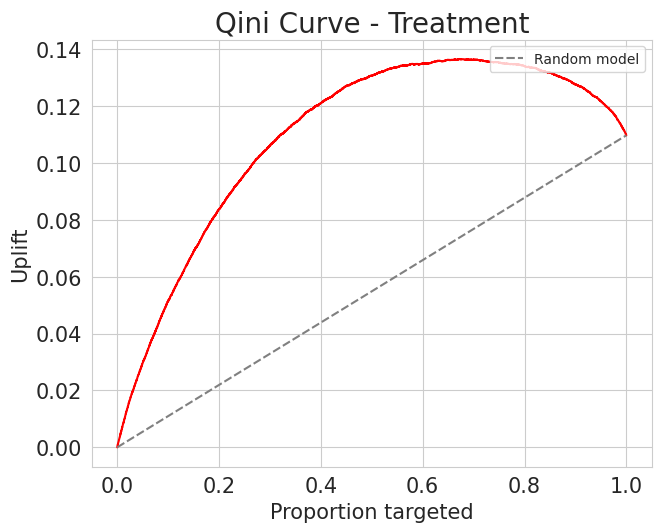

In [ ]:
# plot the Qini curve for BOGO treatment
qini(treatment_uplift)
plt.title('Qini Curve - Treatment',fontsize=20)